<a href="https://colab.research.google.com/github/gianmarcocrn/language-detection-text-classifier/blob/main/language_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q1 - Importing and Adjusting Dataset

In [ ]:
# import csv and cast it into a list of dictionaries
import csv
with open('language_detection.csv', newline='') as csvfile:
    language_samples = list(csv.DictReader(csvfile))
print(len(language_samples))

7249


In [ ]:
# created labels and texts lists
labels, texts = [], []

for sample in language_samples:
  labels.append(sample['Language'])
  texts.append(sample['Text'])

In [ ]:
# checking the data
from collections import Counter
Counter(labels)

Counter({'English': 1385,
         'Portuguese': 739,
         'French': 1014,
         'Dutch': 546,
         'Spanish': 819,
         'Danish': 428,
         'Italian': 698,
         'Turkish': 474,
         'Swedish': 676,
         'German': 470})

In [ ]:
# split data into training, validation, testing set using 60,20,20 ratio
from sklearn.model_selection import train_test_split

texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
texts_train, texts_val, labels_train, labels_val = train_test_split(texts_train, labels_train, test_size=0.25, random_state=42)

Q2 - K-means Clustering

Step 0: Vectorise Text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
sparse_matrix = vectorizer.fit_transform(texts_train)

Step 1: Pick k Random "Centroids"

In [ ]:
import numpy as np
import random

def k_random_centroids(vectorized_text, k):
  initial_random_centroids_indices = random.sample(range(vectorized_text.shape[0]), k)
  random_centroids = [vectorized_text[random_index] for random_index in initial_random_centroids_indices]
  return random_centroids


Step 2: Assign Each Vector to its Closest Vectors

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def assign_to_closest_centroid(centroids, vectorized_text):
  vector_to_closest_centroid_mapping = {}
  for vector_index, vector in enumerate(vectorized_text):
    most_similar_centroid = None
    similarity_scores = []
    for centroid_index, centroid in enumerate(centroids):
      similarity = cosine_similarity(vector.toarray()[0].reshape(1, -1), centroid.toarray()[0].reshape(1, -1))
      similarity_scores.append(similarity[0,0])
    vector_to_closest_centroid_mapping[vector_index] = np.argmax(similarity_scores)
  return vector_to_closest_centroid_mapping

Step 3: Recalculate the Centroids Taking Average of All Vectors Assigned to Each Previous Centroid

In [ ]:
from scipy.sparse import csr_matrix, vstack

def recalculate_centroids(centroids, vectorized_text, vector_to_centroid_mapping):
  new_centroids = []
  for i in range(len(centroids)):
    current_bag = []
    for vector_index,centroid_index in vector_to_centroid_mapping.items():
      if centroid_index == i:
        current_bag.append(vectorized_text[vector_index])
    stacked_arrays = vstack(current_bag)
    new_centroids.append(csr_matrix(np.mean(stacked_arrays, axis=0)))
  return new_centroids

Step 4: Repeat Until Convergence

In [ ]:
def k_means_clustering(k, vectorized_text):
  centroids = k_random_centroids(vectorized_text, k)
  centroid_mapping = assign_to_closest_centroid(centroids, vectorized_text)
  centroid_counter = Counter(centroid_mapping.values())
  i = 0
  while (True):
    print(Counter(centroid_mapping.values()))
    new_centroids = recalculate_centroids(centroids, vectorized_text, centroid_mapping)
    centroid_mapping = assign_to_closest_centroid(new_centroids, vectorized_text)
    new_centroid_counter = Counter(centroid_mapping.values())
    if centroid_counter == new_centroid_counter:
      break
    centroid_counter = new_centroid_counter
    centroids = new_centroids
  return centroid_mapping, centroids

centroid_mapping, final_centroids = k_means_clustering(5, sparse_matrix)

Counter({0: 2916, 4: 865, 2: 219, 3: 209, 1: 140})
Counter({0: 2162, 4: 1138, 1: 444, 2: 315, 3: 290})
Counter({0: 2063, 4: 1093, 1: 531, 3: 386, 2: 276})
Counter({0: 1943, 4: 1004, 1: 630, 3: 494, 2: 278})
Counter({0: 1814, 4: 971, 1: 666, 3: 618, 2: 280})
Counter({0: 1752, 4: 965, 3: 685, 1: 667, 2: 280})
Counter({0: 1701, 4: 953, 3: 748, 1: 667, 2: 280})
Counter({0: 1655, 4: 932, 3: 815, 1: 667, 2: 280})
Counter({0: 1645, 4: 890, 3: 864, 1: 668, 2: 282})
Counter({0: 1624, 3: 923, 4: 854, 1: 667, 2: 281})
Counter({0: 1596, 3: 964, 4: 842, 1: 666, 2: 281})
Counter({0: 1585, 3: 977, 4: 839, 1: 667, 2: 281})
Counter({0: 1577, 3: 985, 4: 839, 1: 667, 2: 281})


Analysing Results: Sampling From Clusters

In [ ]:
print("Texts at Cluster 0")
indices_at_cluster_0 = [k for k, v in centroid_mapping.items() if v == 0]
five_indices_at_0 = random.sample(range(len(indices_at_cluster_0)), 5)
for i in five_indices_at_0: print(texts_train[i]+"\n")
print(Counter([labels_train[i] for i in indices_at_cluster_0]))
print()

print("Texts at Cluster 1")
indices_at_cluster_1 = [k for k, v in centroid_mapping.items() if v == 1]
five_indices_at_1 = random.sample(range(len(indices_at_cluster_1)), 5)
for i in five_indices_at_1: print(texts_train[i]+"\n")
print(Counter([labels_train[i] for i in indices_at_cluster_1]))
print()

print("Texts at Cluster 2")
indices_at_cluster_2 = [k for k, v in centroid_mapping.items() if v == 2]
five_indices_at_2 = random.sample(range(len(indices_at_cluster_2)), 5)
for i in five_indices_at_2: print(texts_train[i]+"\n")
print(Counter([labels_train[i] for i in indices_at_cluster_2]))
print()

print("Texts at Cluster 3")
indices_at_cluster_3 = [k for k, v in centroid_mapping.items() if v == 3]
five_indices_at_3 = random.sample(range(len(indices_at_cluster_3)), 5)
for i in five_indices_at_3: print(texts_train[i]+"\n")
print(Counter([labels_train[i] for i in indices_at_cluster_3]))
print()

print("Texts at Cluster 4")
indices_at_cluster_4 = [k for k, v in centroid_mapping.items() if v == 4]
five_indices_at_4 = random.sample(range(len(indices_at_cluster_4)), 5)
for i in five_indices_at_4: print(texts_train[i]+"\n")
print(Counter([labels_train[i] for i in indices_at_cluster_4]))
print()

Texts at Cluster 0
un altro esempio di catch-22 è che hai bisogno di un prestito bancario perché non ne hai abbastanza.

nej tack ändå, och en annan fras som jag använder i min e-post ibland när jag inte har bett om någon person.

Un altro motivo per cui lo studio dell'apprendimento automatico fu abbandonato fu la pubblicazione del libro Perceptrons: an introduction to computational geometry di Marvin Minsky e Seymour Papert, che vi descrivevano alcune delle limitazioni dei percettroni e delle reti neurali.

Mi dispiace.

Por ejemplo no se podrán clasificar todos aquellas entradas de las que no se haya recibido ninguna información en la fase de entrenamiento.

Counter({'French': 579, 'Italian': 380, 'Dutch': 304, 'Turkish': 269, 'Spanish': 16, 'English': 10, 'Danish': 7, 'German': 5, 'Swedish': 4, 'Portuguese': 3})

Texts at Cluster 1
[19] Op 17 juni 2015 werd de jaarlijkse Prinses van Asturiëprijs voor internationale samenwerking toegekend aan Wikipedia.

y con eso ella se subió a su 

Analysing Results: Top 5 Tokens With the Highest Magnitude in the Corresponding Centroid

In [ ]:
sparse_centroids = [centroid.toarray()[0] for centroid in final_centroids]
top_indices = [np.argsort(centroid)[-5:] for centroid in sparse_centroids]
feature_names = np.array(vectorizer.get_feature_names_out())
for i in range(len(final_centroids)): print(f"Top 5 Tokens for Centroid {i}: {feature_names[top_indices[i]]}")

Top 5 Tokens for Centroid 0: ['un' 'di' 'je' 'la' 'de']
Top 5 Tokens for Centroid 1: ['är' 'och' 'att' 'det' 'du']
Top 5 Tokens for Centroid 2: ['nicht' 'das' 'und' 'sie' 'ich']
Top 5 Tokens for Centroid 3: ['la' 'por' 'no' 'que' 'de']
Top 5 Tokens for Centroid 4: ['in' 'to' 'and' 'of' 'the']


Confusion Matrix code from labs

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plotConfusionMatrixKMeans(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels = ['Danish', 'Dutch', 'English', 'French', 'German', 'Italian', 'Portuguese', 'Spanish', 'Swedish', 'Turkish']
  plot = sn.heatmap(cm[5:,:5], 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=['0','1','2','3','4'], # Put in the X and Y labels
                    yticklabels=labels)
  plot.set(xlabel='Predicted', ylabel='Actual')
  return plot

def plotConfusionMatrix(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels = ['Danish', 'Dutch', 'English', 'French', 'German', 'Italian', 'Portuguese', 'Spanish', 'Swedish', 'Turkish']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels, # Put in the X and Y labels
                    yticklabels=labels)
  plot.set(xlabel='Predicted', ylabel='Actual')
  return plot

K-means Clustering Confusion Matrix

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

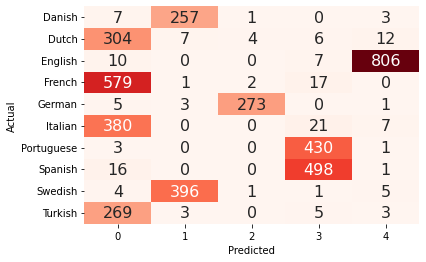

In [ ]:
centroid_mapping_values = list(centroid_mapping.values())
centroid_mapping_values_string = [str(value) for value in centroid_mapping_values]
plotConfusionMatrixKMeans(labels_train, centroid_mapping_values_string)

Q3 - Comparing Classifiers

Q3(a) - Dummy Classifier with strategy="most_frequent"

accuracy=0.190
precision=0.019
recall=0.100
f1=0.032


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


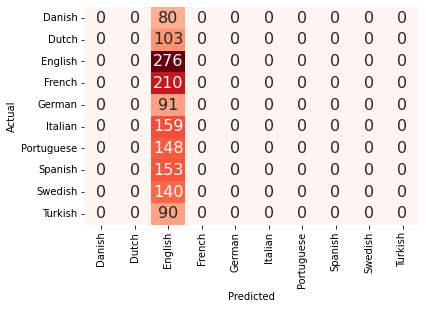

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, labels_train)
labels_predicted = dummy_clf.predict(X_val)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q3(a) - Dummy Classifier with strategy="stratified"

accuracy=0.113
precision=0.101
recall=0.101
f1=0.101


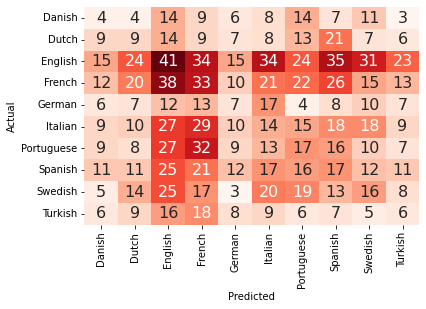

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, labels_train)
labels_predicted = dummy_clf.predict(X_val)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q3(a) - LogisticRegression with One-hot vectorization

accuracy=0.951
precision=0.947
recall=0.950
f1=0.945


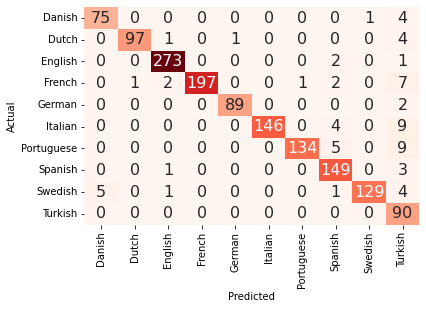

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(binary=True)
X_train_one_hot = vectorizer.fit_transform(texts_train)
X_val_one_hot = vectorizer.transform(texts_val)

clf = LogisticRegression(random_state=42)
clf.fit(X_train_one_hot,labels_train)
labels_predicted = clf.predict(X_val_one_hot)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q3(a) - LogisticRegression with TF-IDF vectorization (Best Performing by Macro-f1 Score)

accuracy=0.964
precision=0.977
recall=0.959
f1=0.967


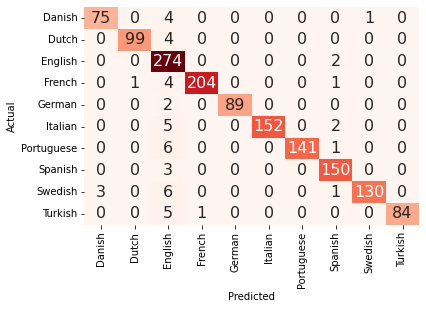

In [ ]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)

clf = LogisticRegression(random_state=42)
clf.fit(X_train,labels_train)
labels_predicted = clf.predict(X_val)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Bar Plot of f1 Score by Class

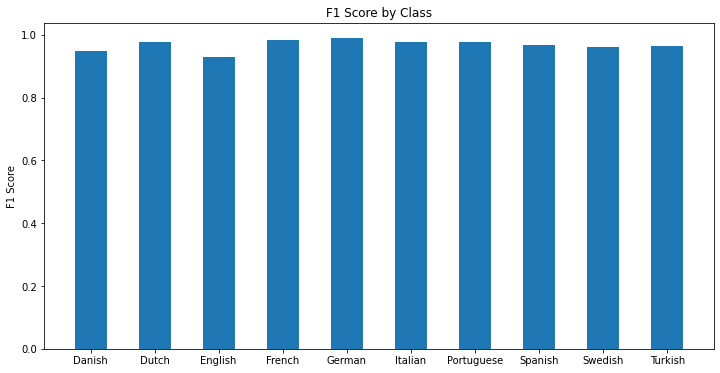

In [ ]:
import matplotlib.pyplot as plt

f1_scores = f1_score(labels_val, labels_predicted, average=None)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(f1_scores)), f1_scores, width=0.5)
ax.set_xticks(range(len(f1_scores)))
ax.set_xticklabels(['Danish', 'Dutch', 'English', 'French', 'German', 'Italian', 'Portuguese', 'Spanish', 'Swedish', 'Turkish'])
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Class')

plt.show()

Q3(a) - SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)

accuracy=0.928
precision=0.934
recall=0.925
f1=0.921


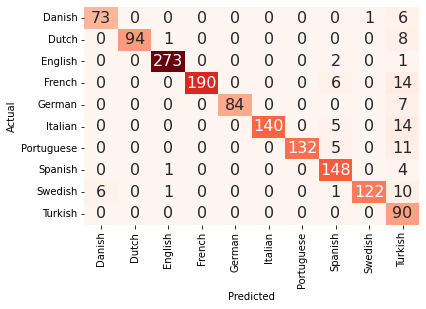

In [23]:
from sklearn.svm import SVC

vectorizer = CountVectorizer(binary=True)
X_train_one_hot = vectorizer.fit_transform(texts_train)
X_val_one_hot = vectorizer.transform(texts_val)

clf = SVC(kernel='rbf')
clf.fit(X_train_one_hot, labels_train)
labels_predicted = clf.predict(X_val_one_hot)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q3(b) - Chosen Classifier: Linear Support Vector Classifier

accuracy=0.972
precision=0.980
recall=0.969
f1=0.974


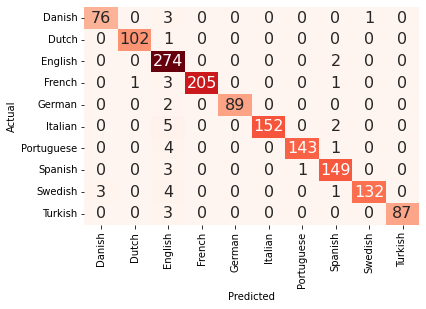

In [24]:
from sklearn.svm import LinearSVC

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)

clf = LinearSVC(random_state=42, C=0.2)
clf.fit(X_train, labels_train)
labels_predicted = clf.predict(X_val)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q4 - Parameter Tuning on LogisticRegression with TF-IDF vectorisation from Q3

accuracy=0.964
precision=0.977
recall=0.960
f1=0.968


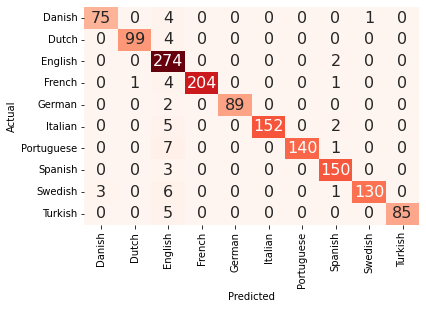

In [25]:
vectorizer = TfidfVectorizer(max_features=20000)
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)
 
clf = LogisticRegression(random_state=42)
clf.fit(X_train,labels_train)
labels_predicted = clf.predict(X_val)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q5 - Context Vectors Using BERT

In [ ]:
!pip install transformers datasets

Q5(a) - LogisticRegression with Context Vectors of First Token in Each Text Sample

In [ ]:
from transformers import pipeline

pipe = pipeline('feature-extraction', model="roberta-base")

In [ ]:
import torch
import re

#stripping numbers and brackets from text before getting the context_vectors out
context_vectors = [pipe(re.sub(r'[0,9]', '', text).strip("[]"), return_tensors='pt', max_length=512, truncation=True)[0,0,:] for text in texts_train]
context_vectors_val = [pipe(re.sub(r'[0,9]', '', text).strip("[]"), return_tensors='pt', max_length=512, truncation=True)[0,0,:] for text in texts_val]

In [ ]:
context_vectors_nd_nparray = torch.stack(context_vectors).detach().numpy()
context_vectors_nd_nparray_val = torch.stack(context_vectors_val).detach().numpy()

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy=0.952
precision=0.954
recall=0.943
f1=0.948


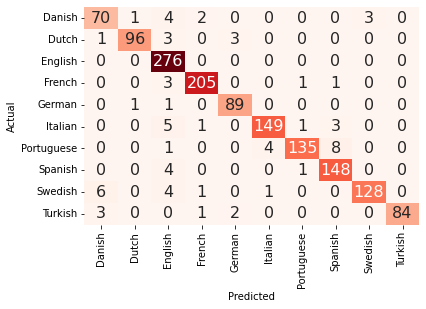

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

clf = LogisticRegression(random_state=42)
clf.fit(context_vectors_nd_nparray, labels_train)
labels_predicted = clf.predict(context_vectors_nd_nparray_val)

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q5(b) - End-to-end Classifier Using HuggingFace Trainer Function

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

id2label = {0:'English', 1:'French', 2:'Spanish', 3:'Portuguese', 4:'Italian', 5:'Swedish', 6:'Dutch', 7:'German', 8:'Turkish', 9:'Danish'}
label2id = {'English': 0, 'French': 1, 'Spanish': 2, 'Portuguese': 3, 'Italian': 4, 'Swedish': 5, 'Dutch': 6, 'German': 7, 'Turkish': 8, 'Danish': 9}

train_dict = {'label':[label2id[label] for label in labels_train], 'text':texts_train}
val_dict = {'label':[label2id[label] for label in labels_val], 'text':texts_val}
test_dict = {'label':[label2id[label] for label in labels_test], 'text':texts_test}

train_dataset = Dataset.from_dict(train_dict)
validation_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

def preprocess_function(examples):
    return tokenizer(examples["text"], max_length=300, padding=True, truncation=True)

In [ ]:
from collections import Counter
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=10, id2label=id2label, label2id=label2id)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_validation = validation_dataset.map(preprocess_function, batched=True)

columns_to_return = ['input_ids', 'label', 'attention_mask']
tokenized_train.set_format(type='torch', columns=columns_to_return)
tokenized_validation.set_format(type='torch', columns=columns_to_return)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import TrainingArguments, Trainer

learning_rate = 1e-4
batch_size = 16
epochs = 1
weight_decay = 0

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
    data_collator=data_collator, 
)

In [ ]:
trainer.train()

***** Running Prediction *****
  Num examples = 1450
  Batch size = 16


accuracy=0.962
precision=0.955
recall=0.953
f1=0.954


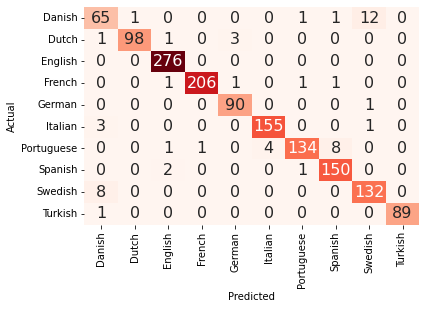

In [ ]:
import numpy as np

prediction_vectors = trainer.predict(tokenized_validation).predictions
labels_predicted = [id2label[np.argmax(prediction_vector)] for prediction_vector in prediction_vectors]

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q5(c) - Pick Different Values For The model, learning_rate, epochs and batch_size.

Q5(c) i: First Set of Hyperparameters --> 'bert-base-multilingual-uncased' Model

In [ ]:
from datasets import Dataset
from collections import Counter
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=10, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_validation = validation_dataset.map(preprocess_function, batched=True)

columns_to_return = ['input_ids', 'label', 'attention_mask']
tokenized_train.set_format(type='torch', columns=columns_to_return)
tokenized_validation.set_format(type='torch', columns=columns_to_return)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import TrainingArguments, Trainer

learning_rate = 1e-4
batch_size = 16
epochs = 1 # This is set low so that the training can happen quickly for this lab.
weight_decay = 0

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=tokenized_train, # The data to use to update the weights
    eval_dataset=tokenized_validation, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

In [ ]:
trainer.train()

In [ ]:
import numpy as np

prediction_vectors = trainer.predict(tokenized_validation).predictions
labels_predicted = [id2label[np.argmax(prediction_vector)] for prediction_vector in prediction_vectors]

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q5(c) ii: Second Set of Hyperparameters --> 'qanastek/51-languages-classifier' model

In [ ]:
from datasets import Dataset
from collections import Counter
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained('qanastek/51-languages-classifier')
model = AutoModelForSequenceClassification.from_pretrained('qanastek/51-languages-classifier', num_labels=10, id2label=id2label, label2id=label2id)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_validation = validation_dataset.map(preprocess_function, batched=True)
 
columns_to_return = ['input_ids', 'label', 'attention_mask']
tokenized_train.set_format(type='torch', columns=columns_to_return)
tokenized_validation.set_format(type='torch', columns=columns_to_return)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import TrainingArguments, Trainer

learning_rate = 1e-4
batch_size = 16
epochs = 1 # This is set low so that the training can happen quickly for this lab.
weight_decay = 0

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=tokenized_train, # The data to use to update the weights
    eval_dataset=tokenized_validation, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

In [ ]:
trainer.train()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

prediction_vectors = trainer.predict(tokenized_validation).predictions
labels_predicted = [id2label[np.argmax(prediction_vector)] for prediction_vector in prediction_vectors]

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q5(c) iii: Third Set of Hyperparameters --> 'qanastek/51-languages-classifier' model with 2 epochs

In [ ]:
from datasets import Dataset
from collections import Counter
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained('qanastek/51-languages-classifier')
model = AutoModelForSequenceClassification.from_pretrained('qanastek/51-languages-classifier', num_labels=10, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_validation = validation_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

columns_to_return = ['input_ids', 'label', 'attention_mask']
tokenized_train.set_format(type='torch', columns=columns_to_return)
tokenized_validation.set_format(type='torch', columns=columns_to_return)
tokenized_test.set_format(type='torch', columns=columns_to_return)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import TrainingArguments, Trainer

learning_rate = 1e-4
batch_size = 16
epochs = 2 # This is set low so that the training can happen quickly for this lab.
weight_decay = 0

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model, # The model you want to train
    args=training_args, # The various training arguments set up above
    train_dataset=tokenized_train, # The data to use to update the weights
    eval_dataset=tokenized_validation, # The data to use for evaluation
    tokenizer=tokenizer, # The tokenizer used on the data
    data_collator=data_collator, # A data collator that does clever things moving data around
)

In [ ]:
trainer.train()

In [ ]:
import numpy as np

prediction_vectors = trainer.predict(tokenized_validation).predictions
labels_predicted = [id2label[np.argmax(prediction_vector)] for prediction_vector in prediction_vectors]

plotConfusionMatrix(labels_val, labels_predicted)

accuracy = accuracy_score(labels_val, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_val, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_val, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_val, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q6 - Conclusions and Future Work

Q6(a) - Evaluate Best Approach on Training Set (Approach from Q5(c)-iii)

***** Running Prediction *****
  Num examples = 1450
  Batch size = 16


accuracy=0.989
precision=0.988
recall=0.988
f1=0.988


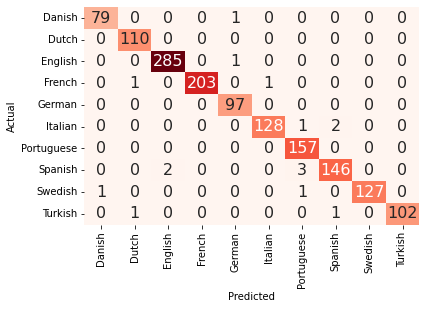

In [ ]:
import numpy as np

prediction_vectors = trainer.predict(tokenized_test).predictions
labels_predicted = [id2label[np.argmax(prediction_vector)] for prediction_vector in prediction_vectors]

plotConfusionMatrix(labels_test, labels_predicted)

accuracy = accuracy_score(labels_test, labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(labels_test, labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(labels_test, labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(labels_test, labels_predicted, average="macro")
print(f"{f1=:.3f}")

Q6(b) - Error Analysis

In [ ]:
for i in range(len(texts_test)):
  if (labels_test[i] != labels_predicted[i]):
    print(texts_test[i], labels_test[i], labels_predicted[i])
    print()

[244]​ En 2010, Alison J. Spanish English

Come va?. Italian Portuguese

rockar du rock? Swedish Portuguese

rocker du rock? Danish German

sí por favor. Spanish Portuguese

apologizing. English German

Herregud. Swedish Danish

Quiero continuar. Spanish Portuguese

mi batte. Italian Spanish

[197]​ Para Assouline et al. Spanish English

Haydi. Turkish Spanish

lo so. Italian Spanish

Cuídate. Spanish Portuguese

izin. Turkish Dutch

Le cinéaste néerlandais IJsbrand van Veelen a créé un documentaire télévisé de 45 minutes en avril 2008, The Truth According to Wikipedia[101]. French Dutch

pardon? French Italian

